Learning to Learn - John Tomlinson, Ahan Maurya, Dr. Jing Wang

First we need to import the modules we created for this notebook

In [20]:
import meta_network
import original_network
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [21]:
# Reload to pick up on-disk changes to original_network
import importlib
importlib.reload(original_network)
importlib.reload(meta_network)

<module 'meta_network' from 'c:\\Users\\bobtt\\OneDrive\\Desktop\\Documents\\JackCS\\learning-to-learn\\cartpole-implementation\\meta_network.py'>

In [22]:
# Reproducibility helpers
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

We will start by initializing both of our networks

In [23]:
cartpole_network, cartpole_target_network,memory, optimizer, device, env = original_network.build_model()

Now lets build a function to graph our reward over time

In [24]:
def plot_rewards(reward_list):
    plt.plot(reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Time')
    plt.scatter(range(len(reward_list)), reward_list, marker='o', color='blue')
    plt.show()


Lets make a training loop to get our baseline performance for our model wihtout the meta learning

In [30]:
NUM_EPISODES = 200
TARGET_UPDATE = 10
MAX_STEPS_PER_EPISODE = 500

In [32]:
def training_loop(
    episodes,
    max_steps=500,
    record_states=False,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    target_update_interval=TARGET_UPDATE,
    gradient_updates=1,
    seed=None,
 ):
    total_reward_list = []
    episodes_states = []
    epsilon = epsilon_start
    best_reward = -np.inf
    global_step = 0

    for episode in range(episodes):
        reset_seed = None if seed is None else seed + episode  # decorrelate while keeping reproducibility
        state, _ = env.reset(seed=reset_seed)
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0.0
        episode_states = [] if record_states else None
        step_count = 0

        while not done and step_count < max_steps:
            action = original_network.select_action(processed_state, cartpole_network, device, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            processed_next_state = original_network.process_state(next_state)

            memory.push(processed_state, action, reward, processed_next_state, done)

            if record_states:
                episode_states.append(next_state)

            processed_state = processed_next_state
            total_reward += reward
            step_count += 1
            global_step += 1

            for _ in range(gradient_updates):
                original_network.optimize_model(cartpole_network, cartpole_target_network, memory, optimizer, device)

            if global_step % target_update_interval == 0:
                original_network.update_target_network(cartpole_network, cartpole_target_network)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        total_reward_list.append(total_reward)

        if record_states and episode_states:
            episodes_states.append(np.array(episode_states))

        if total_reward > best_reward:
            best_reward = total_reward

        window = min(len(total_reward_list), 50)
        moving_avg = np.mean(total_reward_list[-window:]) if window else total_reward
        print(
            f"Episode {episode+1}/{episodes} | Reward: {total_reward:.1f} | Moving Avg ({window}): {moving_avg:.1f} | Epsilon: {epsilon:.3f}"
        )

    if record_states:
        return total_reward_list, episodes_states
    return total_reward_list

Episode 1/200 | Reward: 17.0 | Moving Avg (1): 17.0 | Epsilon: 0.995
Episode 2/200 | Reward: 14.0 | Moving Avg (2): 15.5 | Epsilon: 0.990
Episode 3/200 | Reward: 18.0 | Moving Avg (3): 16.3 | Epsilon: 0.985
Episode 4/200 | Reward: 13.0 | Moving Avg (4): 15.5 | Epsilon: 0.980
Episode 5/200 | Reward: 16.0 | Moving Avg (5): 15.6 | Epsilon: 0.975
Episode 6/200 | Reward: 19.0 | Moving Avg (6): 16.2 | Epsilon: 0.970
Episode 7/200 | Reward: 30.0 | Moving Avg (7): 18.1 | Epsilon: 0.966
Episode 8/200 | Reward: 29.0 | Moving Avg (8): 19.5 | Epsilon: 0.961
Episode 9/200 | Reward: 25.0 | Moving Avg (9): 20.1 | Epsilon: 0.956
Episode 10/200 | Reward: 56.0 | Moving Avg (10): 23.7 | Epsilon: 0.951
Episode 11/200 | Reward: 23.0 | Moving Avg (11): 23.6 | Epsilon: 0.946
Episode 12/200 | Reward: 17.0 | Moving Avg (12): 23.1 | Epsilon: 0.942
Episode 13/200 | Reward: 14.0 | Moving Avg (13): 22.4 | Epsilon: 0.937
Episode 14/200 | Reward: 45.0 | Moving Avg (14): 24.0 | Epsilon: 0.932
Episode 15/200 | Reward:

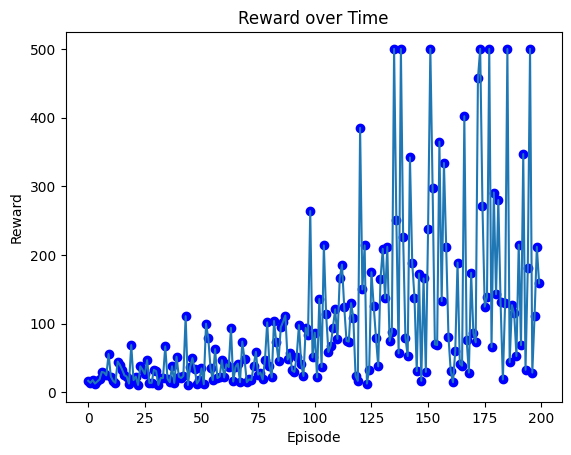

In [33]:
rewards, episodes_states = training_loop(
    NUM_EPISODES,
    record_states=True,
    max_steps=MAX_STEPS_PER_EPISODE,
    seed=SEED,
 )
plot_rewards(rewards)

In [34]:
def compute_state_stats(episodes_states):
    stats = {
        'best_x': [],         
        'avg_x': [],           
        'best_angle': [],      
        'avg_angle': [],       
        'best_x_vel': [],      
        'avg_x_vel': [],       
        'best_angle_vel': [],  
        'avg_angle_vel': []    
    }
   
    for episode_states in episodes_states:

        stats['best_x'].append(np.min(np.abs(episode_states[:, 0])))
        stats['avg_x'].append(np.mean(np.abs(episode_states[:, 0])))

        stats['best_angle'].append(np.min(np.abs(episode_states[:, 2])))
        stats['avg_angle'].append(np.mean(np.abs(episode_states[:, 2])))

        stats['best_x_vel'].append(np.min(np.abs(episode_states[:, 1])))
        stats['avg_x_vel'].append(np.mean(np.abs(episode_states[:, 1])))
        stats['best_angle_vel'].append(np.min(np.abs(episode_states[:, 3])))
        
        stats['avg_angle_vel'].append(np.mean(np.abs(episode_states[:, 3])))
   
    return {k: np.array(v) for k, v in stats.items()}



def plot_state_metric(metric_values, metric_name, color='steelblue'):


    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(metric_values, color=color, linewidth=1.5, label='Metric')
    ax.scatter(range(len(metric_values)), metric_values, marker='o', color=color, s=20, alpha=0.6)
    ax.set_xlabel('Episode')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} over Time')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_state_metrics_all(state_stats):

    metrics = [
        ('best_x', 'Min |Cart Position|'),
        ('avg_x', 'Avg |Cart Position|'),
        ('best_angle', 'Min |Pole Angle|'),
        ('avg_angle', 'Avg |Pole Angle|'),

        ('best_x_vel', 'Min |Cart Velocity|'),
        ('avg_x_vel', 'Avg |Cart Velocity|'),
        ('best_angle_vel', 'Min |Pole Velocity|'),
        ('avg_angle_vel', 'Avg |Pole Velocity|')
    ]
   
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
   
    for idx, (key, title) in enumerate(metrics):
        ax = axes[idx]
        values = state_stats[key]

        ax.plot(values, color='steelblue', linewidth=1.5)
        ax.scatter(range(len(values)), values, marker='o', color='steelblue', s=15, alpha=0.6)

        ax.set_xlabel('Episode')
        ax.set_ylabel(title)

        ax.set_title(title)

        ax.grid(True, alpha=0.3)
   
    plt.tight_layout()
    plt.show()

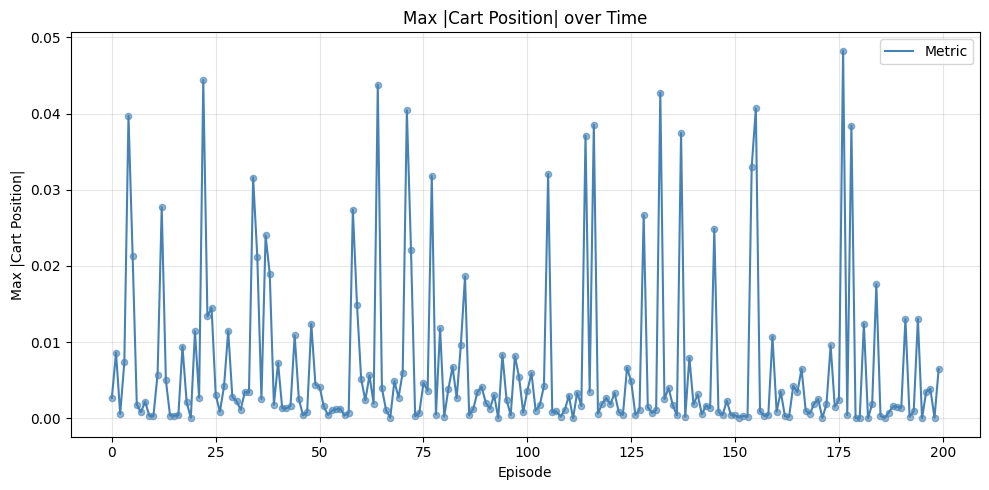

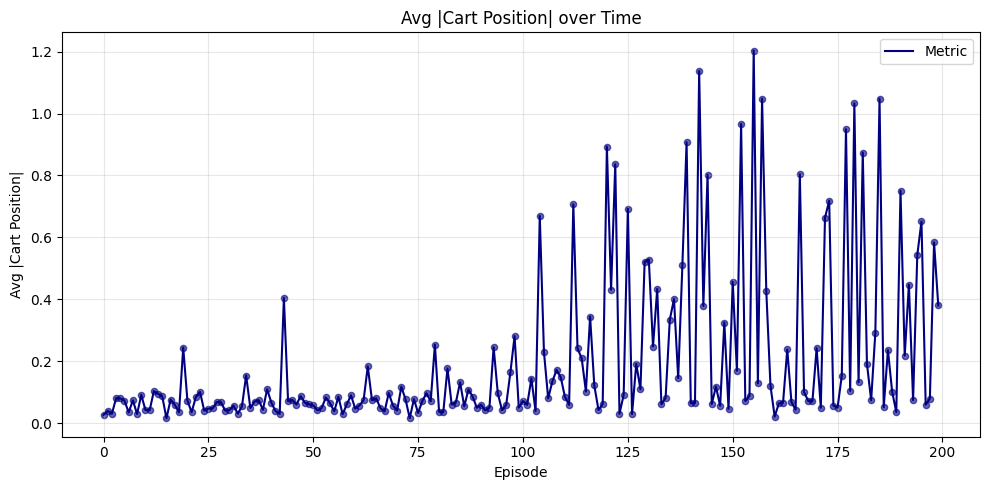

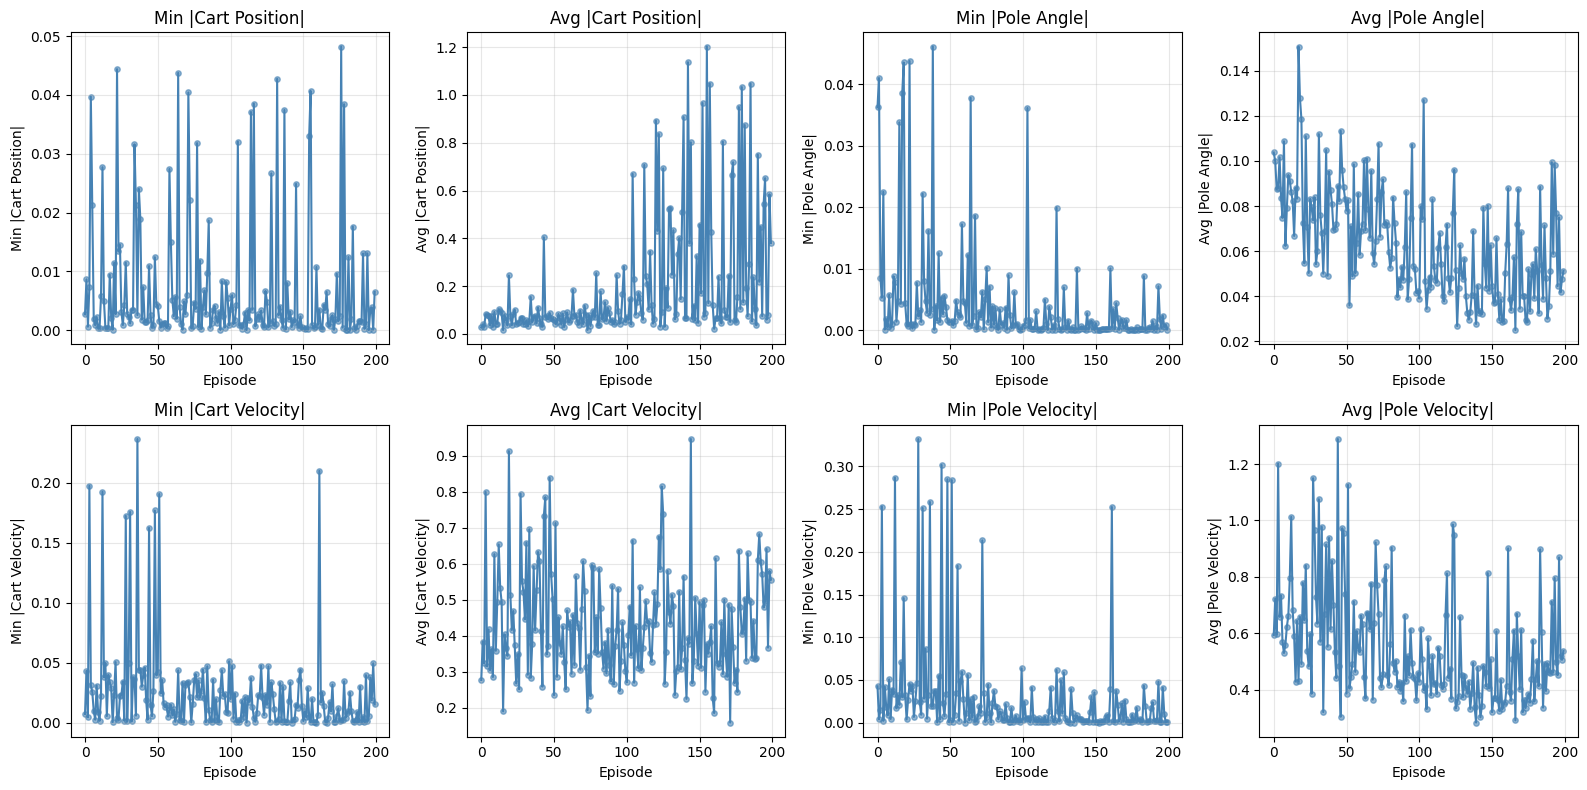

In [35]:

stats = compute_state_stats(episodes_states)


plot_state_metric(stats['best_x'], 'Max |Cart Position|', color='steelblue')
plot_state_metric(stats['avg_x'], 'Avg |Cart Position|', color='navy')


plot_state_metrics_all(stats)


Now that we have a baseline for our reinforcenet learning loop we can try training with our met network that will automatically shape our network.

In [36]:
meta_input_dim = cartpole_network.fc1.in_features + 2  # state features + action + reward context
meta_network_test, meta_memory = meta_network.build_model(meta_input_dim)

In [37]:
#new networks
cartpole_network2, cartpole_target_network2,memory2, optimizer2, device2, env2 = original_network.build_model()

In [40]:
def training_loop_meta(
    episodes,
    max_steps=500,
    epsilon_start=0.5,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    meta_batch_size=128,
    target_update_interval=TARGET_UPDATE,
    seed=None,
 ):
    total_reward_list = []
    epsilon = epsilon_start
    best_reward = -np.inf
    action_trace = []
    global_step = 0
    saved_model = False

    for episode in range(episodes):
        reset_seed = None if seed is None else seed + episode
        state, _ = env2.reset(seed=reset_seed)
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0.0
        step_count = 0
        episode_meta_features = []

        while not done and step_count < max_steps:
            action = original_network.select_action(processed_state, cartpole_network2, device2, epsilon, env2)
            next_state, reward, terminated, truncated, _ = env2.step(action)
            done = terminated or truncated
            processed_next_state = original_network.process_state(next_state)

            shaped_reward, meta_features = meta_network.select_action(
                processed_state,
                action,
                reward,
                meta_network_test,
                device,
                epsilon,
                meta_input_dim,
                return_features=True,
            )

            total_shaped_reward = reward + shaped_reward
            memory2.push(processed_state, action, total_shaped_reward, processed_next_state, done)
            episode_meta_features.append(meta_features)
            action_trace.append(shaped_reward)

            processed_state = processed_next_state
            step_count += 1
            global_step += 1
            total_reward += reward

            original_network.optimize_model(cartpole_network2, cartpole_target_network2, memory2, optimizer2, device2)

            if global_step % target_update_interval == 0:
                original_network.update_target_network(cartpole_network2, cartpole_target_network2)

        meta_reward_data = meta_network.sliding_window(total_reward_list + [total_reward], 50)
        meta_reward_signal = float(meta_network.compute_reward(meta_reward_data))

        if episode_meta_features:
            for features in episode_meta_features:
                meta_memory.push(features, meta_reward_signal)
            meta_network.optimize_model(meta_network_test, meta_memory, device, batch_size=meta_batch_size)

        total_reward_list.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if total_reward > best_reward:
            best_reward = total_reward
        
        if total_reward == 500 and not saved_model:
            torch.save(cartpole_network2.state_dict(), 'best_cartpole_model.pth')
            torch.save(meta_network_test.state_dict(), 'best_meta_network.pth')
            saved_model = True

        window = min(len(total_reward_list), 50)
        moving_avg = np.mean(total_reward_list[-window:]) if window else total_reward
        print(
            f"Meta Episode {episode+1}/{episodes} | Reward: {total_reward:.1f} | Moving Avg ({window}): {moving_avg:.1f} | Meta Reward: {meta_reward_signal:.3f} | Epsilon: {epsilon:.3f}"
        )

    return total_reward_list, action_trace

In [41]:
meta_rewards, action_list = training_loop_meta(
    NUM_EPISODES,
    max_steps=MAX_STEPS_PER_EPISODE,
    seed=SEED,
 )
plot_rewards(meta_rewards)

Meta Episode 1/200 | Reward: 21.0 | Moving Avg (1): 21.0 | Meta Reward: 0.000 | Epsilon: 0.497
Meta Episode 2/200 | Reward: 145.0 | Moving Avg (2): 83.0 | Meta Reward: 124.000 | Epsilon: 0.495
Meta Episode 3/200 | Reward: 288.0 | Moving Avg (3): 151.3 | Meta Reward: 133.500 | Epsilon: 0.493
Meta Episode 4/200 | Reward: 41.0 | Moving Avg (4): 123.8 | Meta Reward: 6.667 | Epsilon: 0.490
Meta Episode 5/200 | Reward: 171.0 | Moving Avg (5): 133.2 | Meta Reward: 37.500 | Epsilon: 0.488
Meta Episode 6/200 | Reward: 348.0 | Moving Avg (6): 169.0 | Meta Reward: 65.400 | Epsilon: 0.485
Meta Episode 7/200 | Reward: 238.0 | Moving Avg (7): 178.9 | Meta Reward: 36.167 | Epsilon: 0.483
Meta Episode 8/200 | Reward: 73.0 | Moving Avg (8): 165.6 | Meta Reward: 7.429 | Epsilon: 0.480
Meta Episode 9/200 | Reward: 403.0 | Moving Avg (9): 192.0 | Meta Reward: 47.750 | Epsilon: 0.478
Meta Episode 10/200 | Reward: 94.0 | Moving Avg (10): 182.2 | Meta Reward: 8.111 | Epsilon: 0.476
Meta Episode 11/200 | Rewa

KeyboardInterrupt: 

In [ ]:
# Load saved policy and meta networks, run one deterministic episode, and visualize reward traces.
from pathlib import Path

POLICY_PATH = Path("best_cartpole_model.pth")
META_PATH = Path("best_meta_network.pth")

if not POLICY_PATH.exists():
    raise FileNotFoundError(f"Saved policy model not found at {POLICY_PATH}")
if not META_PATH.exists():
    raise FileNotFoundError(f"Saved meta network not found at {META_PATH}")

# Policy + env rebuild ensures clean evaluation state.
eval_policy, _, _, _, eval_device, eval_env = original_network.build_model()
eval_policy.load_state_dict(torch.load(POLICY_PATH, map_location=eval_device))
eval_policy.eval()

meta_eval_net, _ = meta_network.build_model(meta_input_dim)
meta_eval_net.to(device)
meta_eval_net.load_state_dict(torch.load(META_PATH, map_location=device))
meta_eval_net.eval()

episode_trace = {
    "step": [],
    "action": [],
    "x": [],
    "x_dot": [],
    "theta": [],
    "theta_dot": [],
    "env_reward": [],
    "meta_reward": [],
    "combined_reward": [],
    "cum_env_reward": [],
    "cum_combined_reward": [],
}

state, _ = eval_env.reset(seed=SEED)
done = False
step = 0
cum_env_reward = 0.0
cum_combined_reward = 0.0

while not done and step < MAX_STEPS_PER_EPISODE:
    x, x_dot, theta, theta_dot = state
    processed_state = original_network.process_state(state)
    action = original_network.select_action(
        processed_state,
        eval_policy,
        eval_device,
        epsilon=0.0,
        env=eval_env,
    )

    next_state, reward, terminated, truncated, _ = eval_env.step(action)
    shaped_reward = meta_network.select_action(
        processed_state,
        action,
        reward,
        meta_eval_net,
        device,
        epsilon=0.0,
        input_dim=meta_input_dim,
        return_features=False,
    )
    combined_reward = reward + shaped_reward

    cum_env_reward += reward
    cum_combined_reward += combined_reward

    episode_trace["step"].append(step)
    episode_trace["action"].append(action)
    episode_trace["x"].append(x)
    episode_trace["x_dot"].append(x_dot)
    episode_trace["theta"].append(theta)
    episode_trace["theta_dot"].append(theta_dot)
    episode_trace["env_reward"].append(reward)
    episode_trace["meta_reward"].append(shaped_reward)
    episode_trace["combined_reward"].append(combined_reward)
    episode_trace["cum_env_reward"].append(cum_env_reward)
    episode_trace["cum_combined_reward"].append(cum_combined_reward)

    state = next_state
    done = terminated or truncated
    step += 1

episode_length = len(episode_trace["step"])
print(f"Loaded policy + meta networks ran for {episode_length} steps using {POLICY_PATH.name} and {META_PATH.name}.")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

axes[0].plot(episode_trace["step"], episode_trace["env_reward"], color="steelblue")
axes[0].set_title("Env Reward per Step")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Reward")

axes[1].plot(episode_trace["step"], episode_trace["meta_reward"], color="darkorange")
axes[1].set_title("Meta Reward per Step")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Shaping Reward")

axes[2].plot(episode_trace["step"], episode_trace["cum_env_reward"], color="navy")
axes[2].set_title("Env Reward Over Time")
axes[2].set_xlabel("Step")
axes[2].set_ylabel("Cumulative Reward")

axes[3].plot(episode_trace["step"], episode_trace["cum_combined_reward"], color="green")
axes[3].set_title("Env + Meta Reward Over Time")
axes[3].set_xlabel("Step")
axes[3].set_ylabel("Cumulative Reward")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

episode_trace